# In-vivo evidence for increased tau deposition in temporal lobe epilepsy

## Content
1.  *Figure 1:* Mapping of tau uptake in TLE
1. Supplementary figures

# **Figure 1:** Mapping of tau uptake in TLE



In [1]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from brainspace.plotting import plot_hemispheres
from osfclient import OSF

# Load utilities functions from utils.py
from utils import *

### Fetch data

In [2]:
osf_path="/Users/rcruces/Desktop/OSF_data_revision-2025"

# Load the data frame
#osf_df = osf_download("18F-MK6240_in-vivo_database.csv", project_id='ct3gw')
#df = pd.read_csv(osf_df)
df = pd.read_csv(f"{osf_path}/18F-MK6240_in-vivo_database_osf.csv")

# Load processed 18F-MK6240 PET data | matrix:{vertices x subjects}
#osf_pet_raw = osf_download("surf-fsLR-32k_desc-GroupData_smooth-10mm_pvc-probGM_ref-cerebellarGM_trc-18Fmk6240_pet.npy", project_id='ct3gw')
#pet_raw = np.load(osf_pet_raw)
pet_raw = np.load(f"{osf_path}/surf-fsLR-32k_desc-GroupData_smooth-10mm_pvc-probGM_ref-cerebellarGM_trc-18Fmk6240_pet.npy")

# Load the cortical thickness data | matrix:{vertices x subjects}
#osf_cth_raw = osf_download("surf-fsLR-32k_desc-GroupData_smooth-20mm_thickness.npy", project_id='ct3gw')
#cth_raw = np.load(osf_cth_raw)
cth_raw = np.load(f"{osf_path}/surf-fsLR-32k_desc-GroupData_smooth-20mm_thickness.npy")

# Load fsLR-32 surface
fslr32k_lh = fetch_surface('fsLR-32k.L.surf.gii')
fslr32k_rh = fetch_surface('fsLR-32k.R.surf.gii')
fslr32k = fetch_template_surface("fslr32k", join=True)

# Load fsLR-32k middle wall mask
fslr32k_mask = fetch_mask("fslr32k")

### Sort the matrices into ipsilateral/contralateral relative to seizure focus

In [3]:
# fsLR-32k length
n_64k = pet_raw.shape[1]
n_32k = int(n_64k/2)

# Flip R >> L 18F-mk6240
mk_ipsi, mk_contra = flip_mat(pet_raw[:,0:n_32k], pet_raw[:,n_32k:n_64k], df['lateralization'].values, flip='R')

# Flip R >> L Thickness
th_ipsi, th_contra = flip_mat(cth_raw[:,0:n_32k], cth_raw[:,n_32k:n_64k], df['lateralization'].values, flip='R')

# Merge ipsi and contra
tauMK6240 = np.concatenate((mk_ipsi, mk_contra), axis=1)
thickness = np.concatenate((th_ipsi, th_contra), axis=1)


Flipping data from Right to Left
Flipping data from Right to Left


## Participants


In [4]:
# Create a cross-tabulation of 'group' and 'mk6240.session'
cross_tab = pd.crosstab(df['group'], df['mk6240.session'], margins=False)

# Print the result in a nice pandas format
display(cross_tab)

mk6240.session   1   2
group                 
Healthy         28   7
Patient         28  13

In [5]:
df

id participant_id  mk6240.session  mk6240.Tdiff sex  age  age.mri1  \
0   hc01_01           hc01               1             0   M   38        36   
1   hc01_02           hc01               2            42   M   41        36   
2   hc02_01           hc02               1             0   M   37        36   
3   hc03_01           hc03               1             0   M   30        29   
4   hc03_02           hc03               2            28   M   33        29   
..      ...            ...             ...           ...  ..  ...       ...   
71  px24_01           px24               1             0   F   31        30   
72  px25_01           px25               1             0   F   35        35   
73  px26_01           px26               1             0   F   47        46   
74  px27_01           px27               1             0   F   61        60   
75  px28_01           px28               1             0   F   50        50   

   handedness Language    group  ... sx.number  engel  ilae.class  \
0           R       en  Healthy  ...       NaN    NaN         NaN   
1           R       en  Healthy  ...       NaN    NaN         NaN   
2           R       en  Healthy  ...       NaN    NaN         NaN   
3           R       en  Healthy  ...       NaN    NaN         NaN   
4           R       en  Healthy  ...       NaN    NaN         NaN   
..        ...      ...      ...  ...       ...    ...         ...   
71          R       en  Patient  ...       NaN    NaN         NaN   
72          R       fr  Patient  ...       NaN    NaN         NaN   
73          R       fr  Patient  ...       NaN    NaN         NaN   
74          R       en  Patient  ...       NaN    NaN         NaN   
75          R       fr  Patient  ...       NaN    NaN         NaN   

   moca.Total.Score EpiTrack.Score.age.corrected Epi.Acc.D.per Epi.Acc.E.per  \
0                29                          NaN     96.428571     96.428571   
1                29                          NaN     96.428571     96.428571   
2                29                         42.0     39.285714     35.714286   
3                30                         39.0     71.428571     85.714286   
4                30                         39.0     71.428571     85.714286   
..              ...                          ...           ...           ...   
71               23                         28.0           NaN           NaN   
72               30                         37.0     92.857143    100.000000   
73               22                         37.0     32.142857     60.714286   
74               27                         35.0           NaN           NaN   
75               21                         31.0     57.142857     60.714286   

    task.retrieval task.semantic  task.spatial  
0         0.964286      0.910714      0.571429  
1         0.964286      0.910714      0.571429  
2         0.375000      0.910714      0.696429  
3         0.785714      0.857143      0.785714  
4         0.785714      0.857143      0.785714  
..             ...           ...           ...  
71        0.000000      0.767857           NaN  
72        0.964286      0.875000           NaN  
73             NaN           NaN           NaN  
74             NaN           NaN           NaN  
75        0.589286      0.732143           NaN  

[76 rows x 31 columns]

------------------------
### A | Mean Tau 18F-MK6240 uptake by group

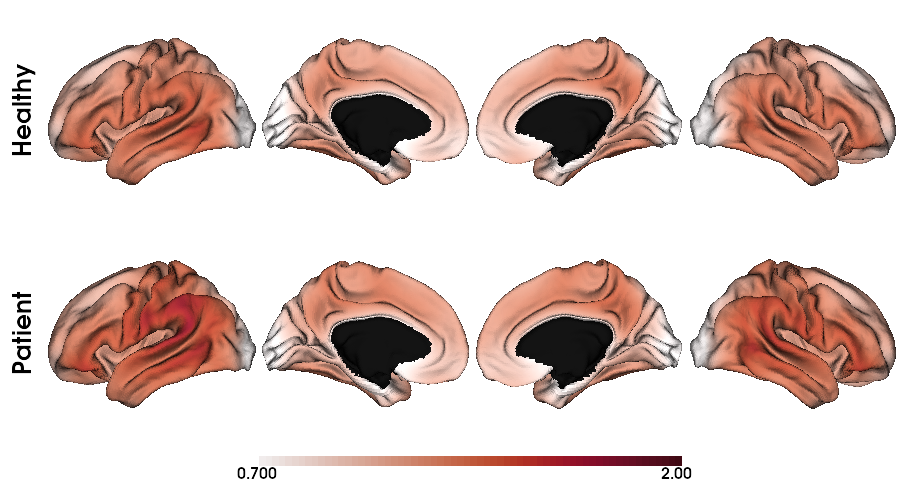

In [6]:
# plot data
plot_ctx_groups(fslr32k_lh, fslr32k_rh, tauMK6240, df , color_range=(0.7, 2), Col='cmo.amp', mask=fslr32k_mask, 
                scale=1, Save=False)


### B.1 | Tau 18F-MK6240 uptake group difference

Y ~ group + age + sex + 1/subject


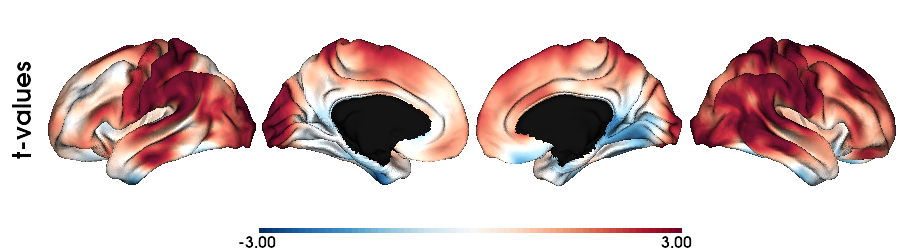

In [7]:
# CREATE the mixed effects model p> 0.01 (p>0.005 per tail) 
slm = mem_groups(Data=tauMK6240, df=df, Surf=fslr32k, mask=fslr32k_mask, Cthr=0.01, mem=True,  Pcorr="rft")

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm, color_range=(-3,3), Str='t-values', Save=False, Col="RdBu_r", mask=fslr32k_mask, scale=1 )


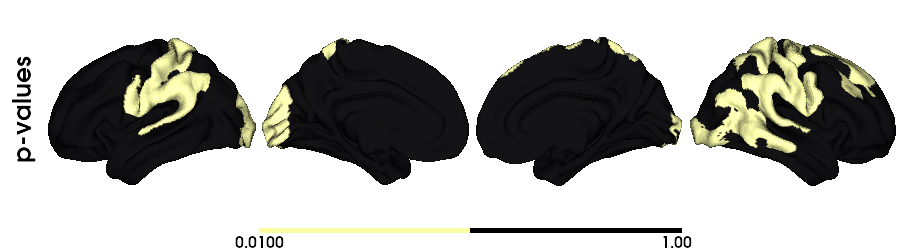

In [8]:
# p>0.025 Plot P-values
plot_ctx_pval(fslr32k_lh, fslr32k_rh, slm, Str='p-values', Save=False, Col="inferno_r", Thr=0.01, scale=1)


In [9]:
# Create a tval map variable
mk6240_tval_map = slm.t[0]

# Save it for Figure 2
np.save(f'{osf_path}/surf-fsLR-32k_desc-tvalues_MixedEffectsModel.npy', mk6240_tval_map)


### B.2 | Mean SUVR values for significant regions in each hemisphere by group

In [10]:
# significant values
thr=0.001
pvalues = np.copy(slm.P["pval"]["C"])

# Merge ipsi and contra
tauMK6240 = np.concatenate((mk_ipsi, mk_contra), axis=1)

# Binarize the significant values
pvalues_bin = np.where(pvalues < thr, 1, 0)

# Split the binarized pvalues in left and right hemispheres
pvalues_bin_ipsi = pvalues_bin[0:n_32k]
pvalues_bin_contra = pvalues_bin[n_32k:n_64k]

# Calculate the mean SIGNIFICANT cortical 18f-mk6240 SUVR
df['mk6240.sig'] = np.mean(tauMK6240[:, pvalues_bin == 1], axis=1)
df['mk6240.sig.ipsi'] = np.mean(mk_ipsi[:, pvalues_bin_ipsi == 1], axis=1)
df['mk6240.sig.contra'] = np.mean(mk_contra[:, pvalues_bin_contra == 1], axis=1)

# Calculate the mean cortical 18f-mk6240 SUVR
df['mk6240.mean'] = np.mean(tauMK6240, axis=1)
df['mk6240.mean.ipsi'] = np.mean(mk_ipsi, axis=1)
df['mk6240.mean.contra'] = np.mean(mk_contra, axis=1)

# Save the significant values on a csv
df.to_csv(f'{osf_path}/18F-MK6240_database.csv', sep=',', encoding='utf-8', index=False, header=True)

Ipsilateral t-value: 4.808
Ipsilateral p-value: 0.00001
Contralateral t-value: 4.612
Contralateral p-value: 0.00002


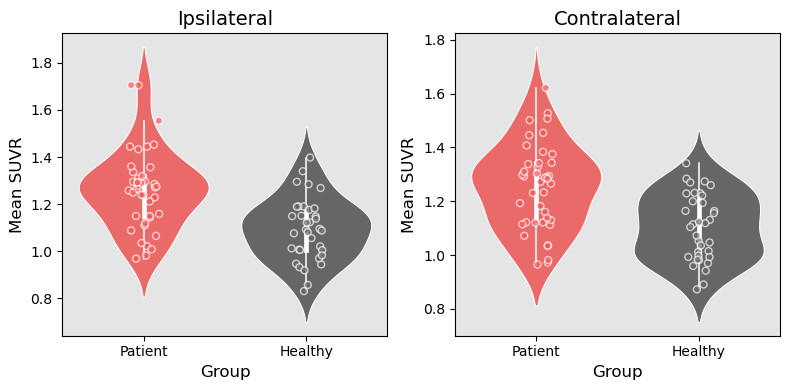

In [11]:
# Define the features and titles
features = ['mk6240.sig.ipsi', 'mk6240.sig.contra']
titles = ['Ipsilateral', 'Contralateral']

# Create a figure with two subplots
plt.figure(figsize=(8, 4))  # Adjust the width to fit two plots

# Loop over the features and titles to create the plots
for i, (feature, title) in enumerate(zip(features, titles)):
    plt.subplot(1, 2, i + 1)  # 1 row, 2 columns, i+1 to select the subplot
    
    # Create violin plot with colored outlines and semi-transparent fill
    sns.violinplot(
        x="group", y=feature, data=df, order=["Patient", "Healthy"], linewidth=0.75, dodge=False,
        hue="group", fill=True, palette={"Patient": "#ff5555", "Healthy": "#666666"}, linecolor="white"
    )

    # Add jittered points (stripplot) with matching colors
    sns.stripplot(
        x="group", y=feature, data=df, jitter=True, order=["Patient", "Healthy"],
        hue="group", palette={"Patient": "#ff5555", "Healthy": "#666666"},
        alpha=0.7, dodge=False, edgecolor="white", linewidth=1, legend=False
    )

    # Set title and labels
    plt.title(title, fontsize=14)
    plt.xlabel("Group", fontsize=12)
    plt.ylabel("Mean SUVR", fontsize=12)

    # Set a lighter gray background (Gray 25: #dcdcdc)
    plt.gca().set_facecolor("#E5E5E5")

    # Perform t-test
    patients = df[df["group"] == "Patient"][feature]
    healthy = df[df["group"] == "Healthy"][feature]
    t_stat, p_value = ttest_ind(patients, healthy, equal_var=False)

    # Print t-test results
    print(f"{title} t-value: {t_stat:.3f}")
    print(f"{title} p-value: {p_value:.5f}")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### C.1 | Subject-Wise Distribution of Cortical MK6240 Uptake
### C.1.a | Ridgeplot of TLE subjects

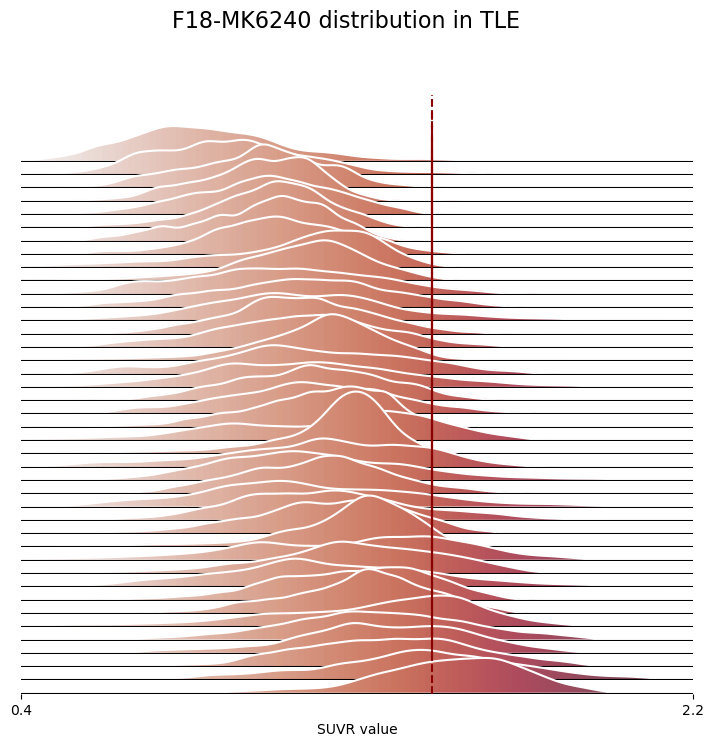

In [12]:
# Slice for the 'Patient' group
tauMK6240_tle = tauMK6240[df['group'] == 'Patient', :]

# Remove the medial wall from the data
tauMK6240_tle_masked = tauMK6240_tle[:, fslr32k_mask]

# Now plot using the filtered data
plot_ridgeplot(tauMK6240_tle_masked,
               title="F18-MK6240 distribution in TLE", 
               Range=(0.4, 2.2), Cmap='cmo.amp', Vline=1.5, save_path=f'{osf_path}/TLE_ridgeplot.png')


### C.1.b | Ridgeplot of Healthy controls

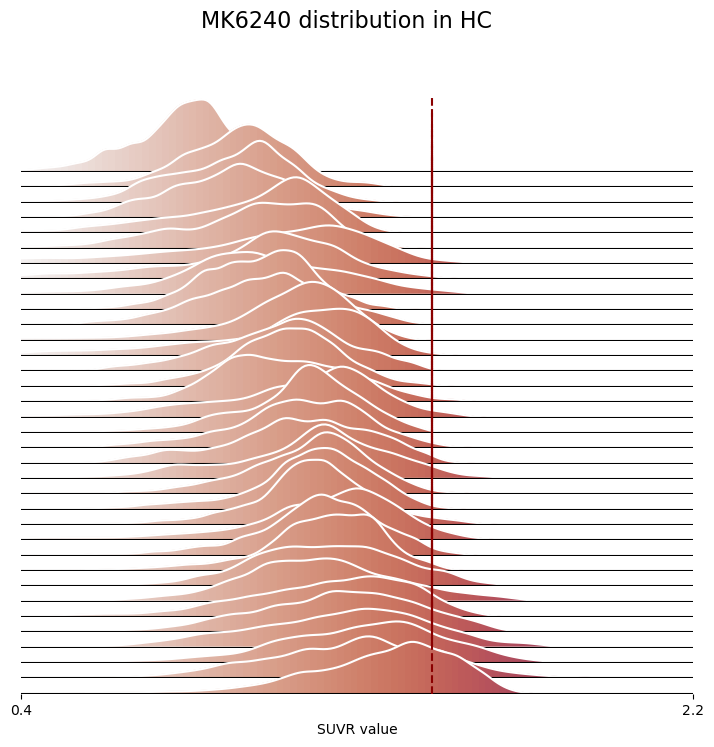

In [13]:
# Filter mk_matched for the 'Healthy' group
tauMK6240_control = tauMK6240[df['group'] == 'Healthy', :]

# Apply the thr_sig mask to select the appropriate columns
tauMK6240_control_masked = tauMK6240_control[:, fslr32k_mask]

# Now plot using the filtered data
plot_ridgeplot(tauMK6240_control_masked,
               title="MK6240 distribution in HC", 
               Range=(0.4, 2.2), Cmap='cmo.amp', Vline=1.5, save_path=f'{osf_path}/HC_ridgeplot.png')


### C.2   | Individual examples of of Cortical [$^{18}F$]-MK6240 Uptake

### C.2.a | TLE subjects

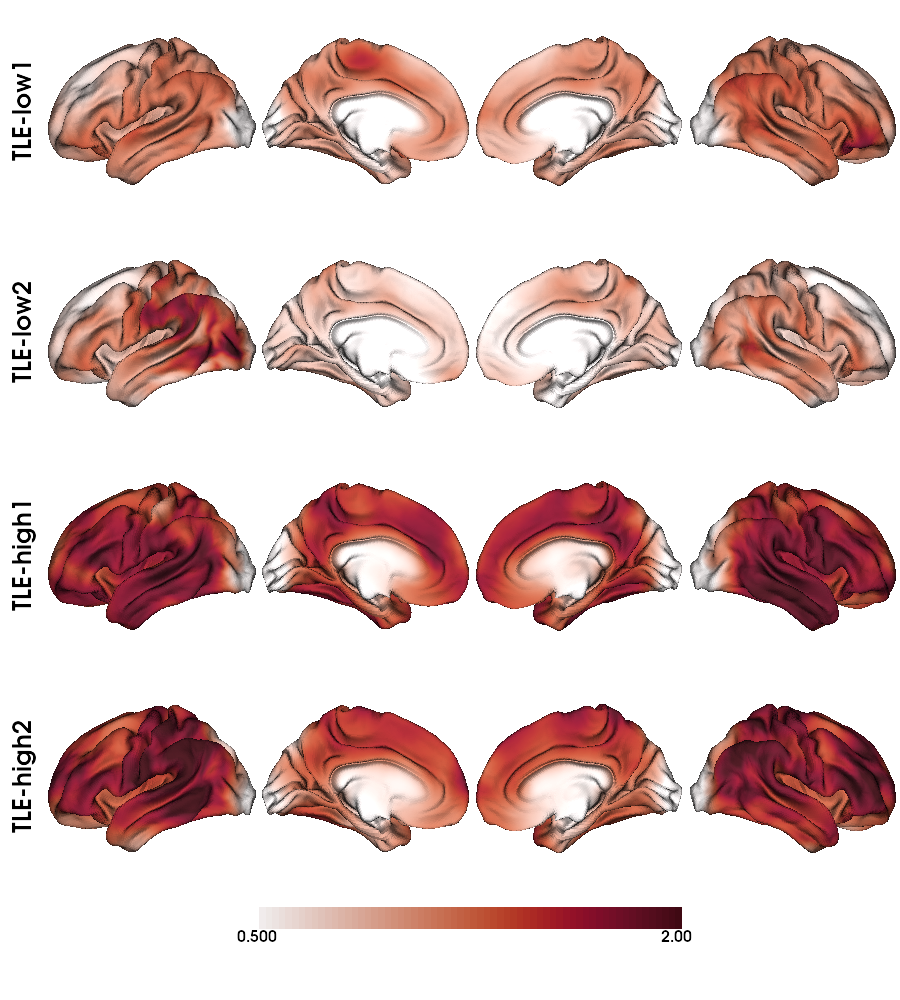

In [14]:
# Low 18F-mk6240
# AGE: 33yrs, DURATION 15yrs, ONSET: 18yrs | px09_01
# AGE: 52yrs, DURATION  2yrs, ONSET: 50yrs | px04_02

# High 18F-mk6240
# AGE: 45yrs, DURATION 38yrs, ONSET: 7yrs  | px10_01
# AGE: 25yrs, DURATION  8yrs, ONSET: 17yrs | px11_02
individual_tle = [
    tauMK6240[df.index[df['id'] == 'px09_01'][0],:],
    tauMK6240[df.index[df['id'] == 'px04_02'][0],:],
    tauMK6240[df.index[df['id'] == 'px10_01'][0],:],
    tauMK6240[df.index[df['id'] == 'px11_02'][0],:] ]

# Plot subjects
plot_hemispheres(fslr32k_lh, fslr32k_rh, array_name=individual_tle, size=(900, 1000),
                 color_bar='bottom', zoom=1.25, embed_nb=True,
                 interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(0.5, 2),
                 cmap='cmo.amp', transparent_bg=True, 
                 label_text=['TLE-low1', 'TLE-low2','TLE-high1', 'TLE-high2'],
                 screenshot=False, scale=1)


### C.2.b | Healthy controls

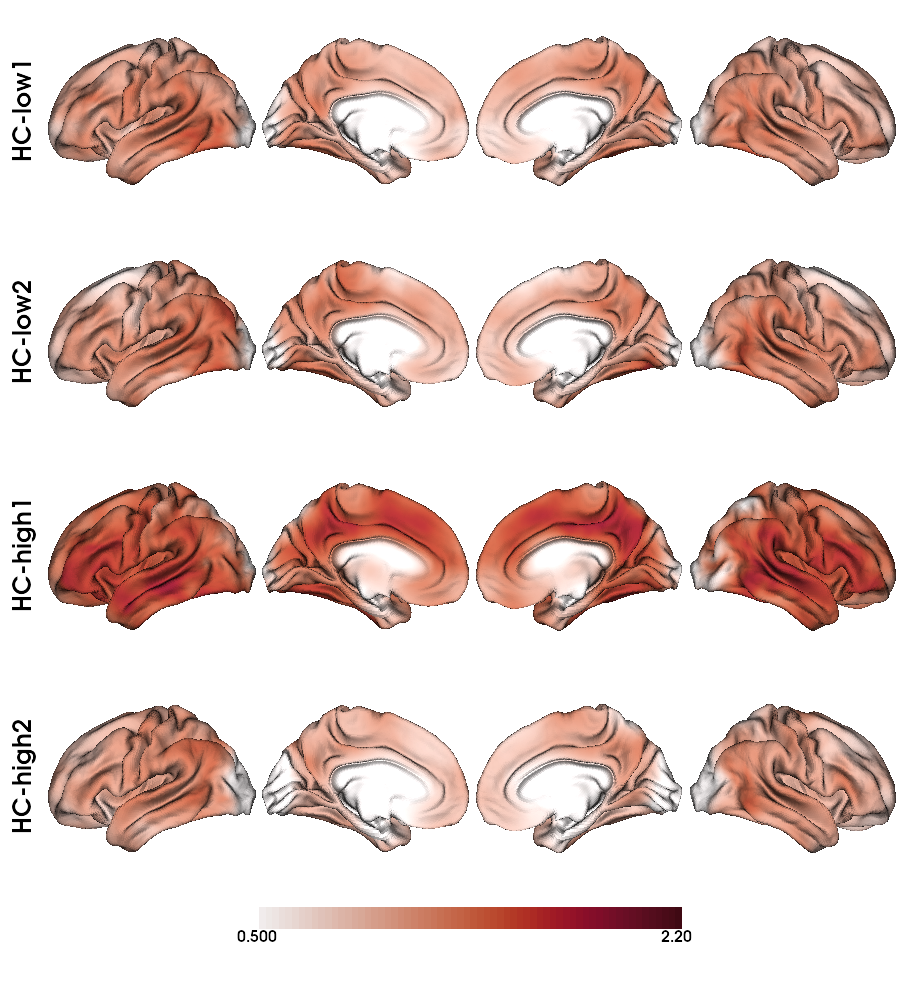

In [15]:
# Subset of subjects HC
individual_hc = [
    tauMK6240[df.index[df['id'] == 'hc10_01'][0],:],
    tauMK6240[df.index[df['id'] == 'hc01_02'][0],:],
    tauMK6240[df.index[df['id'] == 'hc02_01'][0],:],
    tauMK6240[df.index[df['id'] == 'hc11_01'][0],:]
          ]

# Plot subjects
plot_hemispheres(fslr32k_lh, fslr32k_rh, array_name=individual_hc, size=(900, 1000),
                 color_bar='bottom', zoom=1.25, embed_nb=True,
                 interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(0.5, 2.2),
                 cmap='cmo.amp', transparent_bg=True, 
                 label_text=['HC-low1', 'HC-low2', 'HC-high1', 'HC-high2'],
                 screenshot=False, scale=1)


---------------------
# Supplementary figures

## Cortical map of abnormal MK6240 SUVR probability

In [16]:
# Example: compute thresholds
thr_all_99   = np.percentile(tauMK6240[:, fslr32k_mask], 99)
thr_all_975  = np.percentile(tauMK6240[:, fslr32k_mask], 97.5)

thr_ctrl_99  = np.percentile(tauMK6240_control_masked, 99)
thr_ctrl_975 = np.percentile(tauMK6240_control_masked, 97.5)

# Build table
thr_tab = pd.DataFrame({
    "97.5th": [thr_all_975, thr_ctrl_975],
    "99th": [thr_all_99, thr_ctrl_99]
}, index=["All", "Controls"])

# Display nicely
display(thr_tab)


97.5th      99th
All       1.667201  1.785413
Controls  1.552129  1.628347

Percentile: 97.5 in controls is 1.552129444479942


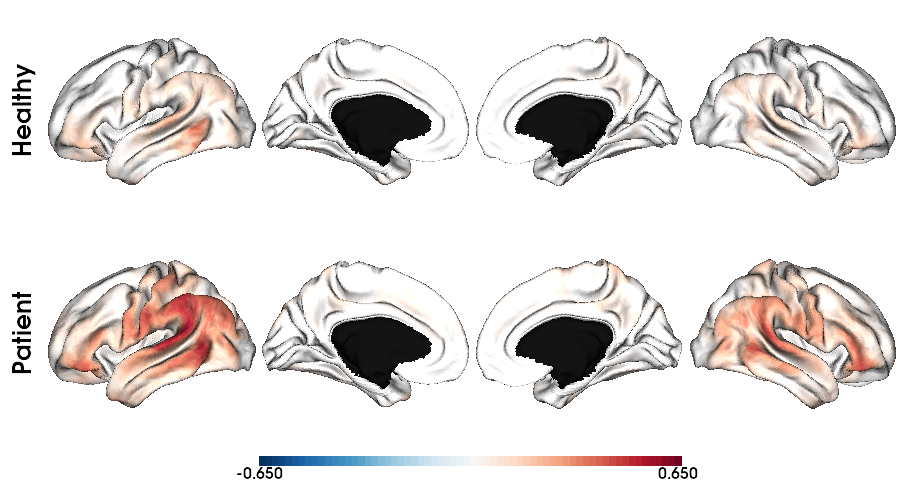

In [17]:
# Percentile based in the controls
thr = np.percentile(tauMK6240_control_masked, 97.5)
print(f"Percentile: 97.5 in controls is {thr}")

# Create a new matrix with values higher than 1.5 set to 1, rest set to 0
tauMK6240_bin = np.where(tauMK6240 > thr, 1, 0)

# plot data
plot_ctx_groups(fslr32k_lh, fslr32k_rh, tauMK6240_bin, df , color_range=(-0.65,0.65), 
                Save=False, Col='RdBu_r', mask=fslr32k_mask, scale=1)


## Group difference in cortical thickness

Y ~ group + age + sex + 1/subject


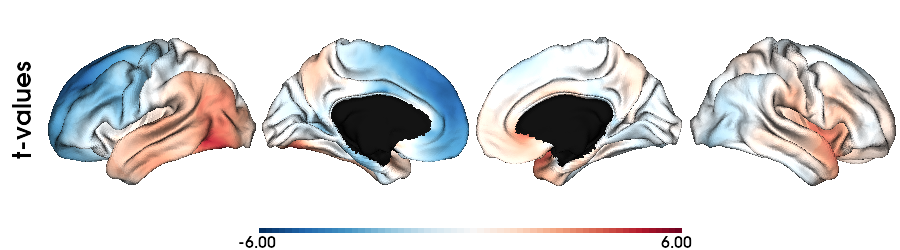

In [18]:
# p>0.025 CREATE the mixed effects model
slm_th = mem_groups(Data=thickness, df=df, Surf=fslr32k, mask=fslr32k_mask, Cthr=0.01, mem=True,  Pcorr="rft")

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm_th, color_range=(-6,6), Str='t-values', Col="RdBu_r", 
             mask=fslr32k_mask, scale=1 )


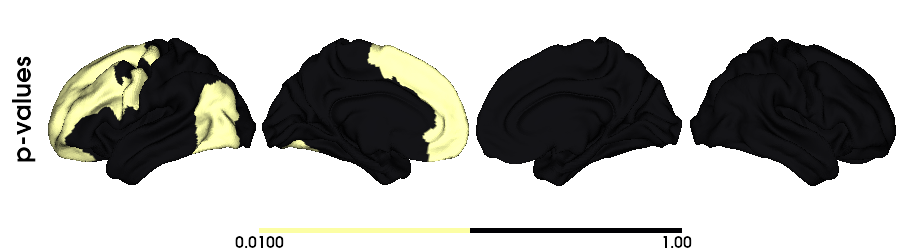

In [19]:
# p>0.025 Plot P-values
plot_ctx_pval(fslr32k_lh, fslr32k_rh, slm_th, Str='p-values', Col="inferno_r", Thr=0.01, scale=1)


## Group difference in MK6240 controlled by thickness

Y ~ group + age + sex + 1/subject


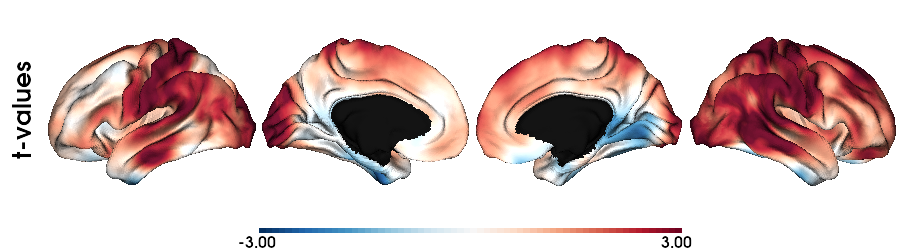

In [20]:
# -------------------------------
# Cortical 18F-MK6240~Thickness
tauMK6240_res = controlVertex(X=thickness, Y=tauMK6240)

# p>0.025 CREATE the mixed effects model
slm_mkth = mem_groups(Data=tauMK6240_res, df=df, Surf=fslr32k, mask=fslr32k_mask, Cthr=0.01, mem=True,  Pcorr="rft")

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm_mkth, color_range=(-3,3), Str='t-values', Col="RdBu_r", 
             mask=fslr32k_mask, scale=1)


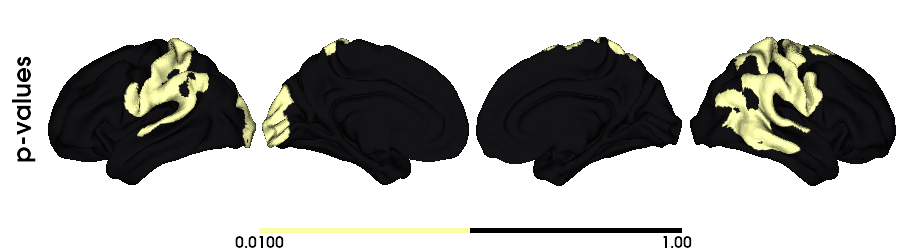

In [21]:
# p>0.025 Plot P-values
plot_ctx_pval(fslr32k_lh, fslr32k_rh, slm_mkth, Str='p-values', Col="inferno_r", Thr=0.01, scale=1)


## Mean longitudinal MK6240 by subject per group

See `Rmarkdown` document